Let us import some standard libraries. Note that this time, we are using one hot encoder module from sklearn.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

Let us use the same class we defined earlier for sigmoid neurons. In addition to mse loss, we also have cross entropy loss function and gradient estimation.

In [28]:
class SigmoidNeuron():
    
    def __init__(self):
        self.w = None
        self.b = None
    
    def perceptron(self, x):
        return np.dot(x, self.w.T) + self.b
        
    def sigmoid(self, x):
        return 1.0/(1.0 + np.exp(-x))
    
    def grad_w_mse(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1-y_pred) * x
    
    def grad_b_mse(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1-y_pred)

    def grad_w_ce(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        if y == 0:
            return y_pred * x
        elif y == 1:
            return -1 * (1 - y_pred) * x
        else:
            raise ValueError("y should be 0 or 1")
    
    def grad_b_ce(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        if y == 0:
            return y_pred 
        elif y == 1:
            return -1 * (1 - y_pred)
        else:
            raise ValueError("y should be 0 or 1")

    
    def fit(self, X, Y, epochs=1, learning_rate=1, initialize=True, loss_fn='mse', display_loss=False):
        if initialize:
            self.w = np.random.randn(1, X.shape[1])
            self.b = 0

        if display_loss:
            loss= {}
        for i in range(epochs):
            dw = 0
            db = 0
            for x,y in zip(X,Y):
                if loss_fn == 'mse':
                    dw = dw + self.grad_w_mse(x, y)
                    db = db + self.grad_b_mse(x, y)
                elif loss_fn == 'ce':
                    dw = dw + self.grad_w_ce(x, y)
                    db = db + self.grad_b_ce(x, y)

            m = X.shape[1] 
            self.w = self.w - learning_rate*dw/m
            self.b = self.b - learning_rate*db/m

            Y_pred = self.predict(X)
            if loss_fn == 'mse':
                loss[i] = mean_squared_error(Y, Y_pred)
            if loss_fn == 'ce':
                loss[i] = log_loss(Y, Y_pred)
        if display_loss == True:
            plt.plot(loss.values())
            plt.xlabel('epochs')
            if loss_fn == 'mse':
                plt.ylabel('mean squared error loss')
            elif loss_fn == 'ce':
                plt.ylabel('cross entropy loss')
            plt.show()
            
    def predict(self, X):
        Y_pred = []
        for x in X:
            y_pred = self.sigmoid(self.perceptron(x))
            Y_pred.append(y_pred)
        return np.array(Y_pred)

Let us also add the cmap.

In [37]:
np.random.seed(0)

In [38]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",['red','yellow','green'])

Let us now generate the classification data.

In [45]:
data, labels = make_blobs(n_samples = 1000, centers = 4, n_features = 2, random_state = 0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


And also plot the data to see what we have got.

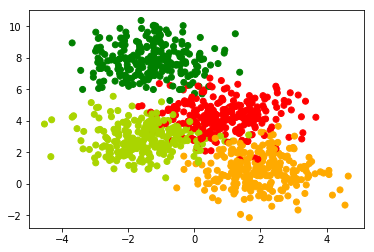

In [46]:
plt.scatter(x=data[:,0], y=data[:,1], c=labels, cmap = my_cmap)
plt.show()

For the purpose of binary classification, let us now convert that labels in as 0 and 1. 

In [47]:
labels_orig = labels
labels = np.mod(labels_orig,2)

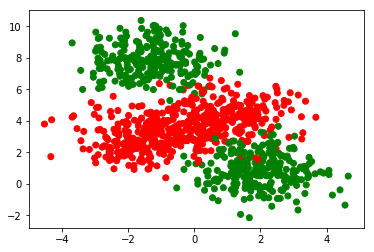

In [48]:
plt.scatter(x=data[:,0], y=data[:,1], c=labels, cmap = my_cmap)
plt.show()

Let us now do train test split.

In [49]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify = labels, random_state = 0)
print(X_train.shape, X_val.shape)

(750, 2) (250, 2)


Now, let us train a sigmoid neuron.

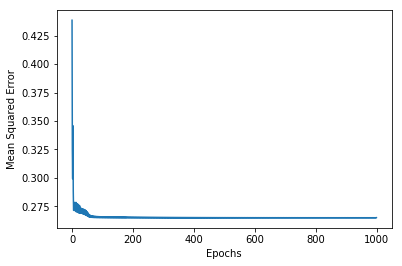

In [51]:
sn = SigmoidNeuron()
sn.fit(X_train, Y_train, epochs=1000, learning_rate = 0.5, loss_fn= 'mse', display_loss=True)

In [10]:
Y_pred_train = sn.predict(X_train)
Y_pred_binarized_train = (Y_pred_train > 0.5).astype(int).ravel()
Y_pred_val = sn.predict(X_val)
Y_pred_binarized_val = (Y_pred_val > 0.5).astype(int).ravel()

accuracy_train = accuracy_score(Y_pred_binarized_train, Y_train)
accuracy_val = accuracy_score(Y_pred_binarized_val, Y_val)

print('Training accuracy', round(accuracy_train,2))
print('Validation accuracy', round(accuracy_val,2))

Training accuracy 0.51
Validation accuracy 0.52


Let us now visualize the results using scatter plot with size as one of the dimension. The smaller size indicated the data that has been correctly classified whereas the green are the ones that sigmoid neuron could not classify correctly.

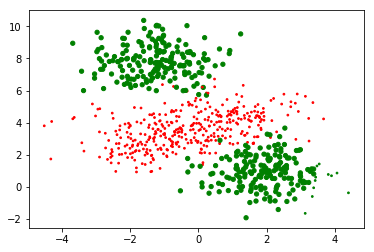

In [11]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap = my_cmap, s = 15*(np.abs(Y_pred_binarized_train-Y_train)+0.2))
plt.show()

Let us now write a class for feed forward neural network. This will serve as a good base for future code development.

In [12]:
class FFSNNetwork:
  
  def __init__(self, n_inputs, hidden_sizes=[2]):
    self.nx = n_inputs
    self.ny = 1
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny]
    
    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh+1):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    return self.H[self.nh+1]
  
  def grad_sigmoid(self, x):
    return x*(1-x) 
    
  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))
    
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, display_loss=False):
    
    # initialise w, b
    if initialise:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
    if display_loss:
      loss = {}
    
    for e in range(epochs):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x, y in zip(X, Y):
        self.grad(x, y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
        
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * dW[i+1] / m
        self.B[i+1] -= learning_rate * dB[i+1] / m
      
      if display_loss:
        Y_pred = self.predict(X)
        loss[e] = mean_squared_error(Y_pred, Y)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('Mean Squared Error')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()

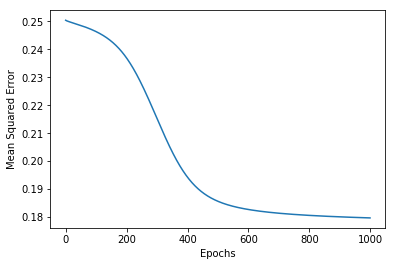

In [13]:
ffsnn = FFSNNetwork(2, [2, 3])
ffsnn.fit(X_train, Y_train, epochs=1000, learning_rate=.001, display_loss=True)